# Compute embeddings of translation regulated elements

In [1]:
from embedding import model_selection
import torch
import os
import random
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm

/opt/anaconda3/envs/torch201/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.chdir('/picb/rnasys2/zhouhanwen/nucTran/github')

## Process data

In [3]:
rna_df = pd.read_csv('embedding/data/FunctionalElement/gencode_element.tsv', sep='\t')
len(rna_df)

19375

In [4]:
np.random.seed(2024)
# rna_sample_df = rna_df[(rna_df['seq_len'] > 4096) & (rna_df['seq_len'] <= 14500)].copy()
rna_sample_df = rna_df[rna_df['seq_len'] <= 4096].copy()
rna_sample_df.reset_index(inplace=True)
len(rna_sample_df)

14984

In [5]:
rna_sample_df['utr5_end'] = rna_sample_df['utr5_start'] + rna_sample_df['utr5_len']
rna_sample_df['utr3_end'] = rna_sample_df['utr3_start'] + rna_sample_df['utr3_len']
print(rna_sample_df['utr5_len'].median())
print(rna_sample_df['utr3_len'].median())

124.0
498.0


## Compute embeddings

In [6]:
model_state_path = 'pretrain/saving_model/mammalian80D_4096len1mer1sw_80M/checkpoint-250000/model.safetensors'
# model_state_path = None
model_max_length = 15000
device = torch.device("cuda:1")
tokenizer, model = model_selection(model_state_path, model_max_length)
model = model.to(device)

In [7]:
utr5_embedding_means = []
cds_embedding_means = []
utr3_embedding_means = []

model.eval()
with torch.no_grad():
    for i in tqdm.trange(len(rna_sample_df)):
        seq = rna_sample_df.loc[i, 'seq_rna']
        utr5_start = rna_sample_df.loc[i, 'utr5_start']
        utr5_end = rna_sample_df.loc[i, 'utr5_end']
        utr3_start = rna_sample_df.loc[i, 'utr3_start']
        utr3_end = rna_sample_df.loc[i, 'utr3_end']

        inputs = tokenizer(seq, return_tensors="pt")
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        outputs = model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        outputs = outputs.last_hidden_state[0, 1 : -1, :]
        utr5_embedding_mean = torch.mean(outputs[utr5_start:utr5_end, :], dim=0).tolist()
        utr5_embedding_means.append(utr5_embedding_mean)
        cds_embedding_mean = torch.mean(outputs[utr5_end:utr3_start, :], dim=0).tolist()
        cds_embedding_means.append(cds_embedding_mean)
        utr3_embedding_mean = torch.mean(outputs[utr3_start:utr3_end, :], dim=0).tolist()
        utr3_embedding_means.append(utr3_embedding_mean)

100%|█████████████████████████████████████████████████████████████████████████████| 14984/14984 [41:05<00:00,  6.08it/s]


In [8]:
embedding_means = np.array(utr5_embedding_means + cds_embedding_means + utr3_embedding_means)
embedding_means.shape

(44952, 768)

In [9]:
np.save('embedding/data/FunctionalElement/functional_element_embedding_mean_mammalian80D_4096len1mer1sw_80M_250k_mRNA_lt4096.npy', embedding_means)
# np.save('embedding/data/FunctionalElement/functional_element_embedding_mean_no_pretrain_80M_mRNA_gt4096_lt14500.npy', embedding_means)

In [10]:
num = int(embedding_means.shape[0] / 3)
num

14984

In [11]:
labels = ['red'] * num + ['blue'] * num + ['green'] * num

## Compute NMI

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embedding_means)

In [13]:
normalized_mutual_info_score(labels, cluster_labels)

0.5312380503669347

In [14]:
label_df = pd.DataFrame({'predict_label': cluster_labels, 'true_label': labels})
pd.crosstab(label_df['true_label'], label_df['predict_label'])

predict_label,0,1,2
true_label,,,
blue,495,14296,193
green,12339,2479,166
red,3684,950,10350


## tSNE

In [15]:
tsne = TSNE(n_components=2, init='pca', verbose=2, random_state=2024)
tsne_array = tsne.fit_transform(embedding_means)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 44952 samples in 0.035s...
[t-SNE] Computed neighbors for 44952 samples in 10.499s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44952
[t-SNE] Computed conditional probabilities for sample 2000 / 44952
[t-SNE] Computed conditional probabilities for sample 3000 / 44952
[t-SNE] Computed conditional probabilities for sample 4000 / 44952
[t-SNE] Computed conditional probabilities for sample 5000 / 44952
[t-SNE] Computed conditional probabilities for sample 6000 / 44952
[t-SNE] Computed conditional probabilities for sample 7000 / 44952
[t-SNE] Computed conditional probabilities for sample 8000 / 44952
[t-SNE] Computed conditional probabilities for sample 9000 / 44952
[t-SNE] Computed conditional probabilities for sample 10000 / 44952
[t-SNE] Computed conditional probabilities for sample 11000 / 44952
[t-SNE] Computed conditional probabilities for sample 12000 / 44952
[t-SNE] Computed conditional probabilities for sa

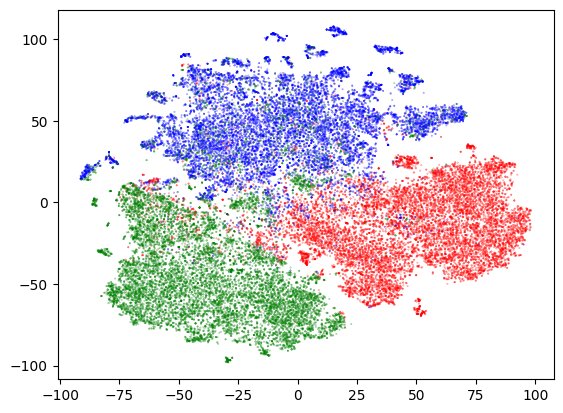

In [16]:
plt.scatter(tsne_array[:, 0], tsne_array[:, 1], c=labels, alpha=0.5, s=0.1)

In [17]:
tsne_df = pd.DataFrame(tsne_array)
tsne_df.columns = ['tsne1', 'tsne2']
tsne_df['label'] = ["utr5"] * len(rna_sample_df) + ["cds"] * len(rna_sample_df) + ['utr3'] * len(rna_sample_df)

In [18]:
tsne_df.to_csv('embedding/data/FunctionalElement/functional_element_embedding_mean_mammalian80D_4096len1mer1sw_80M_250k_mRNA_lt4096_tsne.tsv', sep='\t', index=False)
# tsne_df.to_csv('embedding/data/FunctionalElement/functional_element_embedding_mean_no_pretrain_80M_mRNA_lt4096_tsne.tsv', sep='\t', index=False)